In [ ]:
import torch
import os

numEpoch=10
batchSize=5
reSize=512

device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

train="trainData"
valid="testData"

classes=["background","Ball"]

numClasses=2

VISUALIZE_TRANSFORMED_IMAGES=False

output="output"

save_plot_epoch=2
save_model_epoch=2
print(classes)

['background', 'Ball']


In [ ]:
import albumentations as A
import cv2
import numpy as np

from albumentations.pytorch import ToTensorV2

class Averager:
  def __init__(self):
    self.currTotal=0.0
    self.iterations=0

  def send(self, value):
    self.currTotal+=value
    self.iterations+=1

  @property
  def value(self):
    if self.iterations==0:
      return 0
    else:
      return 1.0*self.currTotal/self.iterations

  def reset(self):
    self.iterations=0
    self.currTotal=0.0

def collate_fn(batch):
  return tuple(zip(*batch))

def getTrainTransform():
  return A.Compose([
      A.Flip(0.5),
      A.RandomRotate90(0.5),
      A.MotionBlur(p=0.2),
      A.MedianBlur(blur_limit=3, p=0.1),
      A.Blur(blur_limit=3, p=0.1),
      ToTensorV2(p=1.0),
  ], bbox_params={
      'format' : 'pascal_voc',
      'label_fields' : ['labels']
  })

def getValidTransform():
  return A.Compose([
      ToTensorV2(p=1.0),
  ], bbox_params={
      'format':'pascal_voc',
      'label_fields':['labels']
  })

def showTransformedImage(trainLoader):
  '''Only runs if VISUALIZE_TRANSFORMED_IMAGES=True'''
  if len(trainLoader)>0:
    for i in range(1):
      images, targets=next(iter(trainLoader))
      images1=[]
      for image in images:
        images1.append(image.to(device))
      targets=[{k: v.to(device) for k,v in t.items()} for t in targets]
      boxes=targets[i]["boxes"].cpu().numpy().astype(np.int32)
      sample=images1[i].permute(1,2,0).cpu().numpy()
      for box in boxes:
        cv2.rectangle(sample, (box[0], box[1]), (box[2],box[3]), (0,255,0), 2)

      cv2.imshow('Transformed image', sample)
      cv2.waitKey(0)
      cv2.destroyAllWindows()
print(classes)

['background', 'Ball']


(tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.9490, 0.9490, 0.9490],
         [1.0000, 1.0000, 1.0000,  ..., 0.9490, 0.9490, 0.9490],
         [1.0000, 1.0000, 1.0000,  ..., 0.9490, 0.9490, 0.9490],
         ...,
         [0.9373, 0.9373, 0.9373,  ..., 0.9255, 0.9255, 0.9255],
         [0.9373, 0.9373, 0.9373,  ..., 0.9255, 0.9256, 0.9295],
         [0.9373, 0.9373, 0.9373,  ..., 0.9330, 0.9373, 0.9373]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.9373, 0.9373, 0.9373],
         [1.0000, 1.0000, 1.0000,  ..., 0.9373, 0.9373, 0.9373],
         [1.0000, 1.0000, 1.0000,  ..., 0.9373, 0.9373, 0.9373],
         ...,
         [0.9216, 0.9216, 0.9216,  ..., 0.9373, 0.9373, 0.9373],
         [0.9216, 0.9216, 0.9216,  ..., 0.9373, 0.9374, 0.9413],
         [0.9216, 0.9216, 0.9216,  ..., 0.9448, 0.9490, 0.9490]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.9529, 0.9529, 0.9529],
         [1.0000, 1.0000, 1.0000,  ..., 0.9529, 0.9529, 0.9529],
         [1.0000, 1.0000, 1.0000,  ..., 0.9529, 0.9529, 0

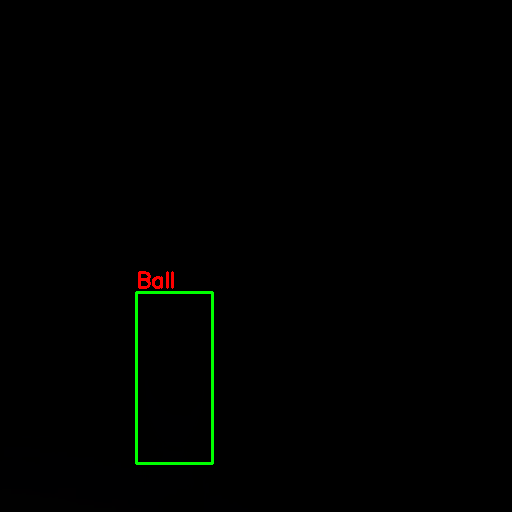

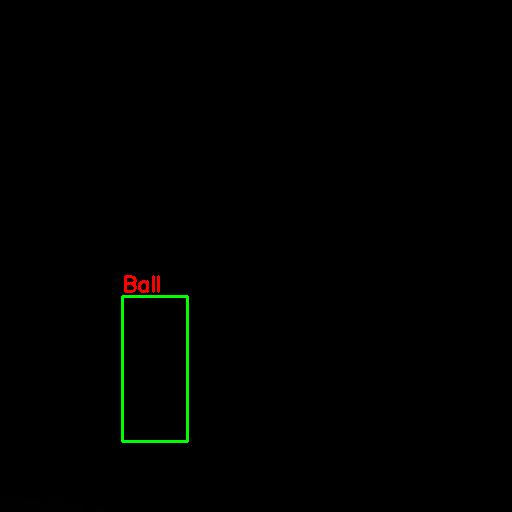

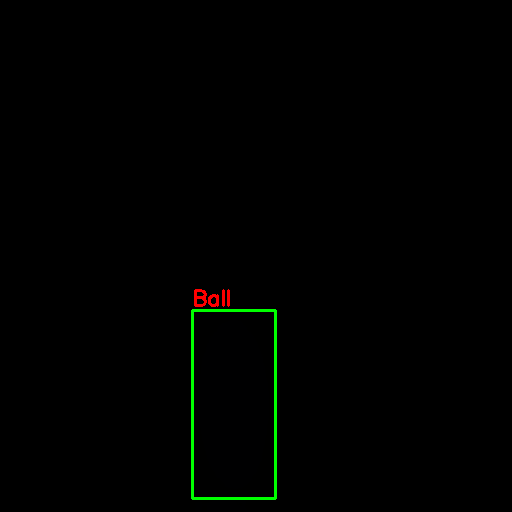

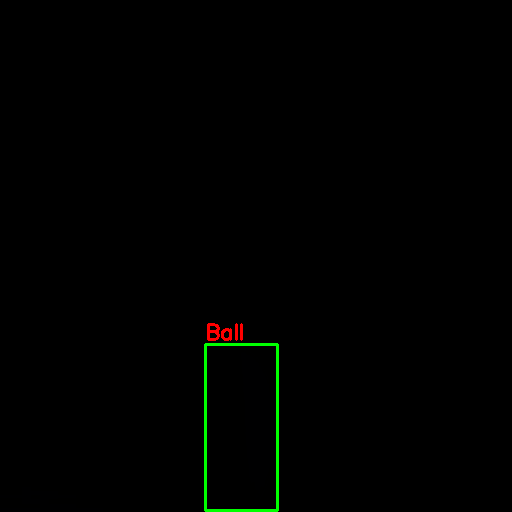

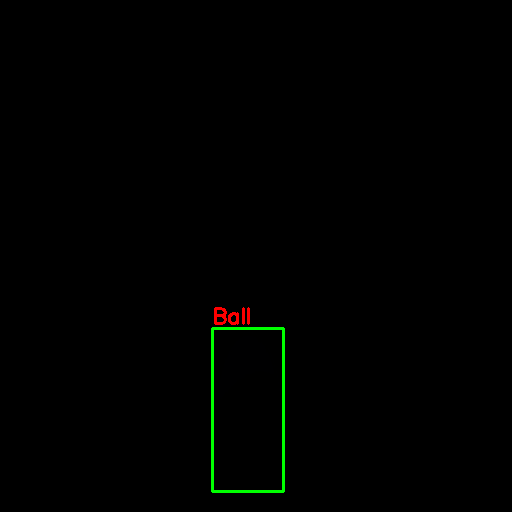

In [ ]:
import torch
import cv2
import numpy as np
import os
import glob as glob

from xml.etree import ElementTree as et

from torch.utils.data import Dataset, DataLoader
from google.colab.patches import cv2_imshow

class CustomData(Dataset):
  def __init__(self, dirPath, width, height, classes, transforms=None):
    self.transforms=transforms
    self.dirPath=dirPath
    self.width=width
    self.height=height
    self.classes=classes

    self.imagePaths=glob.glob(f"{self.dirPath}/*.png")
    self.allImages=[imagePath.split('/')[-1] for imagePath in self.imagePaths]
    self.allImages=sorted(self.allImages)
    #print(self.allImages)

  def __getitem__(self, idx):
    image=self.allImages[idx]
    imagePath=os.path.sep.join([self.dirPath, image])

    img=cv2.imread(imagePath)

    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    imgResized=cv2.resize(img, (self.width, self.height))
    imgResized/=255.0

    annotName=image[:-4]+'.xml'
    annotPath=os.path.sep.join([self.dirPath, annotName])

    boxes=[]
    labels=[]
    tree=et.parse(annotPath)
    root=tree.getroot()

    h=img.shape[0]
    w=img.shape[1]

    for member in root.findall('object'):
      labels.append(self.classes.index(member.find('name').text))

      xMin=int(member.find('bndbox').find('xmin').text)
      xMax=int(member.find('bndbox').find('xmax').text)
      yMin=int(member.find('bndbox').find('ymin').text)
      yMax=int(member.find('bndbox').find('ymax').text)

      xMin=(xMin/w)*self.width
      xMax=(xMax/w)*self.width
      yMin=(yMin/h)*self.height
      yMax=(yMax/h)*self.height

      boxes.append([xMin,yMin,xMax,yMax])

    boxes=torch.as_tensor(boxes, dtype=torch.float32)

    area=(boxes[:,3]-boxes[:,1])*(boxes[:,2]-boxes[:,0])

    iscrowd=torch.zeros((boxes.shape[0],), dtype=torch.int64)

    labels=torch.as_tensor(labels, dtype=torch.int64)


    target={}
    target["boxes"]=boxes
    target["labels"]=labels
    target["iscrowd"]=iscrowd
    image_id = torch.tensor([idx])
    target["image_id"]=image_id

    if self.transforms:
      sample=self.transforms(image=imgResized,
                             bboxes=target["boxes"],
                             labels=labels)
      imgResized=sample["image"]
      target["boxes"]=torch.tensor(sample["bboxes"])
    return  imgResized, target

  def __len__(self):
    return len(self.allImages)


trainDS=CustomData(train,reSize, reSize, classes, getTrainTransform())
print(trainDS[0])
validDS=CustomData(valid, reSize, reSize, classes, getValidTransform())

trainLoader=DataLoader(
    trainDS,
    batch_size=batchSize,
    shuffle=True,
    num_workers=os.cpu_count(),
    collate_fn=collate_fn
)

validLoader=DataLoader(
    validDS,
    batch_size=batchSize,
    shuffle=True,
    num_workers=os.cpu_count(),
    collate_fn=collate_fn
)

print(f"Number of training samples = {len(trainDS)}")
print(f"Number of validation samples = {len(validDS)}")

if __name__ == "__main__":
  dataset=CustomData(train, reSize, reSize, classes)
  print(f"Number of training samples = {len(dataset)}")

  def visualize_sample(image, target):
    box=target['boxes'][0]
    label=classes[target['labels']]
    cv2.rectangle(image, (int(box[0]), int(box[1])),(int(box[2]), int(box[3])), (0,255,0), 2)
    cv2.putText(image, label, (int(box[0]), int(box[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
    cv2_imshow(image)
    cv2.waitKey(0)

  numSamplestoVisualize=5
  for i in range(numSamplestoVisualize):
    image, target = dataset[i]
    visualize_sample(image, target)
#print(trainDS[0])

In [ ]:
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def createModel(numClasses):
  model=torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

  in_features=model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor=FastRCNNPredictor(in_features, numClasses)

  return model


In [ ]:
from torch.nn.modules import loss
from tqdm.auto import tqdm

import torch
import time
import matplotlib.pyplot as plt

plt.style.use('ggplot')

def train(trainDataLoader, model):
  print("Training")
  global train_itr
  global train_loss_list

  progBar=tqdm(trainDataLoader, total=len(trainDataLoader))

  for i, data in enumerate(progBar):
    optimizer.zero_grad()
    images, targets = data
    images1=[]
    for image in images:
      images1.append(image.to(device))
    targets=[{k: v.to(device) for k,v in t.items()} for t in targets]

    lossDict=model(images1, targets)

    losses=sum(loss for loss in lossDict.values())
    lossValue=losses.item()
    train_loss_list.append(lossValue)

    train_loss_hist.send(lossValue)

    losses.backward()

    optimizer.step()

    train_itr+=1

    progBar.set_description(desc=f"Loss : {lossValue:.4f}")

  return train_loss_list

def validate(validDataLoader, model):
  print("Validating")
  global val_itr
  global val_loss_list

  progBar=tqdm(validDataLoader, total=len(validDataLoader))

  for i, data in enumerate(progBar):
    images, targets = data
    images1=[]

    for image in images:
      images1.append(image.to(device))
    targets=[{k: v.to(device) for k,v in t.items()} for t in targets]

    with torch.no_grad():
      lossDict=model(images1, targets)

    losses=sum(loss for loss in lossDict.values())
    lossValue=losses.item()
    val_loss_list.append(lossValue)

    val_loss_hist.send(lossValue)

    val_itr+=1

    progBar.set_description(desc=f"Loss = {lossValue:.4f}")
  return val_loss_list

if __name__=="__main__":
  model=createModel(numClasses=numClasses)
  model=model.to(device)

  params=[p for p in model.parameters() if p.requires_grad]

  optimizer=torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

  train_loss_hist=Averager()
  val_loss_hist=Averager()
  train_itr=1
  val_itr=1

  train_loss_list=[]
  val_loss_list=[]

  modelName='model'

  if VISUALIZE_TRANSFORMED_IMAGES:
    showTransformedImage(trainLoader)

  for epoch in range(numEpoch):
    print(f"Epoch {epoch+1} in {numEpoch}")

    train_loss_hist.reset()
    val_loss_hist.reset()

    figure1, trainAx=plt.subplots()
    figure2, validAx=plt.subplots()

    start=time.time()

    trainLoss=train(trainLoader, model)
    valLoss=validate(validLoader, model)

    print(f"Epoch #{epoch} train loss : {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch} validate loss : {val_loss_hist.value:.3f}")

    end=time.time()
    print(f"Took {((end-start)/60):.3f} minutes for epoch")

    if (epoch+1) % save_model_epoch == 0:
      torch.save(model.state_dict(), f"model{epoch+1}.pth")
      print("SAVING MODEL COMPLETE..........")

    if (epoch+1) % save_plot_epoch == 0:
      trainAx.plot(trainLoss, color="blue")
      trainAx.set_xlabel("Iterations")
      trainAx.set_ylabel("Train Loss")
      validAx.plot(valLoss, color='red')
      validAx.set_xlabel("Iterations")
      validAx.set_ylabel("Validation Loss")
      figure1.savefig(f"train_loss_{epoch+1}.png")
      figure2.savefig(f"valid_loss_{epoch+1}.png")
      print("SAVING PLOT IMAGES..........")

    if (epoch+1)==numEpoch:
      trainAx.plot(trainLoss, color="blue")
      trainAx.set_xlabel("Iterations")
      trainAx.set_ylabel("Train Loss")
      validAx.plot(valLoss, color='red')
      validAx.set_xlabel("Iterations")
      validAx.set_ylabel("Validation Loss")
      figure1.savefig(f"train_loss_{epoch+1}.png")
      figure2.savefig(f"valid_loss_{epoch+1}.png")

      torch.save(model.state_dict(), f"model{epoch+1}.pth")

    plt.close('all')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 323MB/s]


Epoch 1 in 10
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #0 train loss : 0.326
Epoch #0 validate loss : 0.200
Took 0.428 minutes for epoch
Epoch 2 in 10
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #1 train loss : 0.172
Epoch #1 validate loss : 0.161
Took 0.284 minutes for epoch
SAVING MODEL COMPLETE..........
SAVING PLOT IMAGES..........
Epoch 3 in 10
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #2 train loss : 0.124
Epoch #2 validate loss : 0.106
Took 0.291 minutes for epoch
Epoch 4 in 10
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #3 train loss : 0.083
Epoch #3 validate loss : 0.072
Took 0.296 minutes for epoch
SAVING MODEL COMPLETE..........
SAVING PLOT IMAGES..........
Epoch 5 in 10
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #4 train loss : 0.061
Epoch #4 validate loss : 0.052
Took 0.302 minutes for epoch
Epoch 6 in 10
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #5 train loss : 0.050
Epoch #5 validate loss : 0.040
Took 0.310 minutes for epoch
SAVING MODEL COMPLETE..........
SAVING PLOT IMAGES..........
Epoch 7 in 10
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #6 train loss : 0.045
Epoch #6 validate loss : 0.037
Took 0.322 minutes for epoch
Epoch 8 in 10
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #7 train loss : 0.040
Epoch #7 validate loss : 0.043
Took 0.318 minutes for epoch
SAVING MODEL COMPLETE..........
SAVING PLOT IMAGES..........
Epoch 9 in 10
Training


  0%|          | 0/17 [00:00<?, ?it/s]

Validating


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #8 train loss : 0.040
Epoch #8 validate loss : 0.034
Took 0.312 minutes for epoch
Epoch 10 in 10
Training


Exception ignored in: 

  0%|          | 0/17 [00:00<?, ?it/s]

<function _MultiProcessingDataLoaderIter.__del__ at 0x7fec742c8670>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fec742c8670>    
Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():
self._shutdown_workers()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'    if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Assert

Validating


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #9 train loss : 0.037
Epoch #9 validate loss : 0.033
Took 0.325 minutes for epoch
SAVING MODEL COMPLETE..........
SAVING PLOT IMAGES..........


Hey


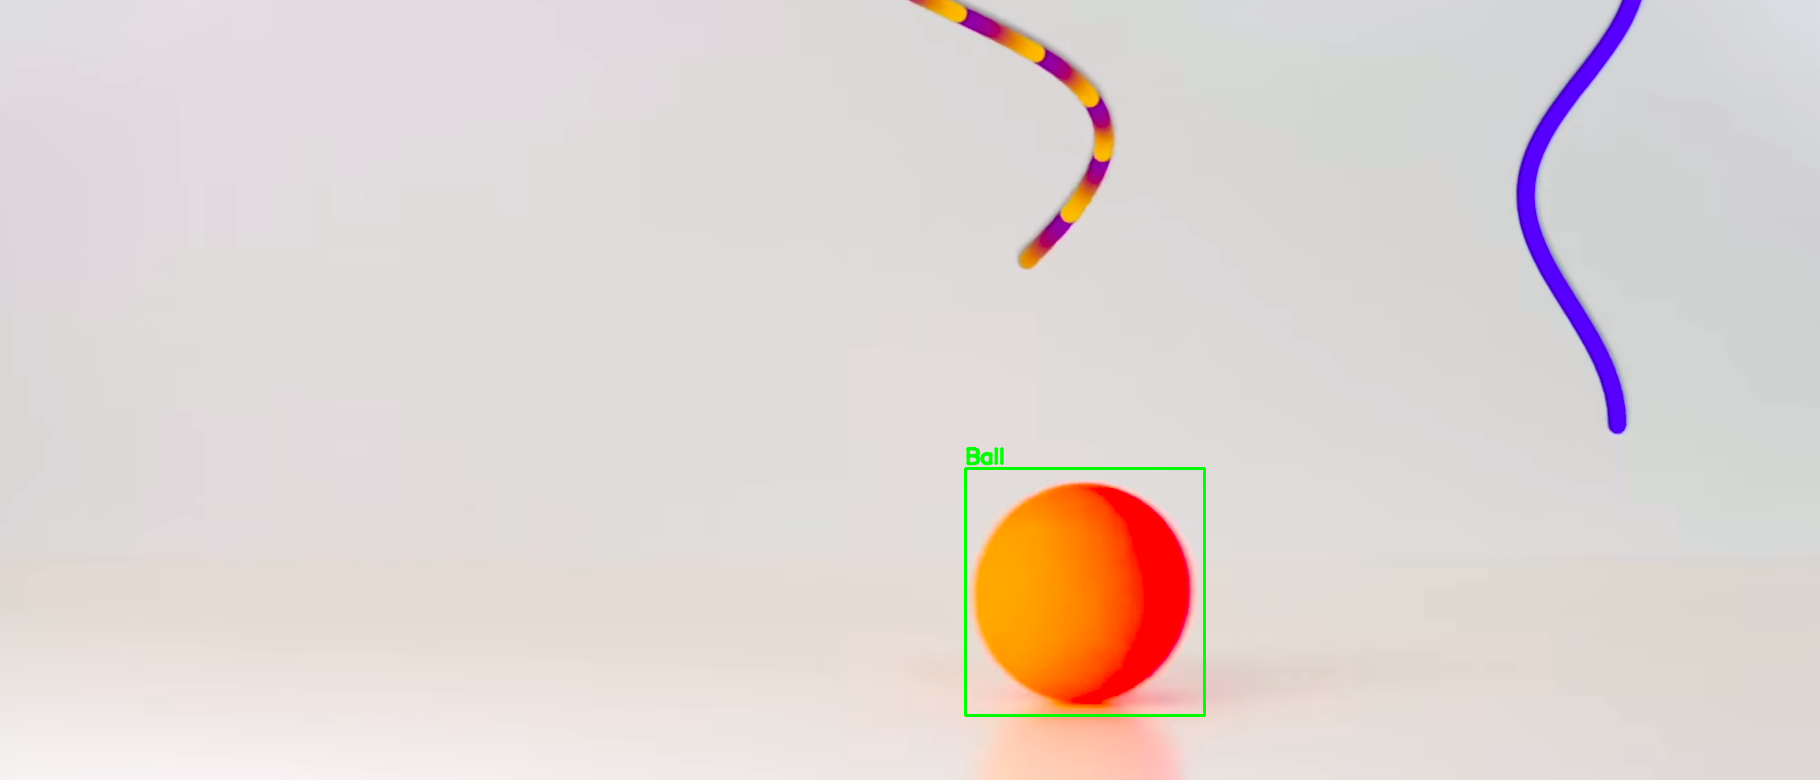

TEST COMPLETE


In [ ]:
import os
import numpy as np
import torch
import cv2

from google.colab.patches import cv2_imshow




modelPth="model10.pth"
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model=createModel(numClasses=2)
model.load_state_dict(torch.load(modelPth, map_location=device))
model.to(device)
model.eval()


detThresh=0.95

image=cv2.imread("/content/testData/89.png")
orig=image.copy()

image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

image/=255.0

image=np.transpose(image, (2,0,1)).astype(float)

image=torch.tensor(image, dtype=torch.float).cuda()

image=torch.unsqueeze(image, 0)

with torch.no_grad():
  outputs=model(image)

outputs=[{k: v.to('cpu') for k,v in t.items()} for t in outputs]

if (len(outputs[0]['boxes'])!=0):
  print("Hey")
  boxes=outputs[0]['boxes'].data.numpy()
  scores=outputs[0]['scores'].data.numpy()

  boxes=boxes[scores>=detThresh].astype(np.int32)

  draw=boxes.copy()

  predclasses=[classes[i] for i in outputs[0]['labels'].cpu().numpy()]

  for j, box in enumerate(draw):
    cv2.rectangle(orig, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0,255,0), 2)
    cv2.putText(orig, predclasses[j], (int(box[0]), int(box[1])-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2, lineType=cv2.LINE_AA)

cv2_imshow(orig)
cv2.waitKey(1)
#cv2.imwrite(f"testcomplete.jpg", orig)
print("TEST COMPLETE")

cv2.destroyAllWindows()
